# Summary of Results

In [1]:
import pandas as pd
import tools as ds
from IPython.display import Image

## Data Description

In [2]:
crashes_initial = pd.read_csv('data/Crashes.csv')
crashes_initial.head()

CASE_ID  ACCIDENT_YEAR   PROC_DATE  JURIS COLLISION_DATE  COLLISION_TIME  \
0  7034739           2015  2015-08-22   3801     2015-02-26            1931   
1  7035304           2014  2015-08-24   3801     2014-12-25            2245   
2  7202472           2016  2016-03-09   3801     2016-02-11            1100   
3  8042422           2016  2016-05-16   3801     2016-04-13            1050   
4  8046723           2016  2016-05-18   3801     2016-04-16            1614   

  OFFICER_ID REPORTING_DISTRICT  DAY_OF_WEEK  CHP_SHIFT  ...  COUNT_MC_KILLED  \
0     000985              RICHM            4          5  ...                0   
1     A09861              INGLE            4          5  ...                0   
2       1572                NaN            4          5  ...                0   
3     001588              CENTR            3          5  ...                0   
4       2472              MISIS            6          5  ...                0   

   COUNT_MC_INJURED  PRIMARY_RAMP  SECONDARY_RAMP LATITUDE  LONGITUDE  \
0                 0            -               -       NaN        NaN   
1                 0            -               -       NaN        NaN   
2                 0            -               -       NaN        NaN   
3                 0            -               -       NaN        NaN   
4                 0            -               -       NaN        NaN   

          COUNTY           CITY     POINT_X    POINT_Y  
0  SAN FRANCISCO  SAN FRANCISCO -122.458750  37.779350  
1  SAN FRANCISCO  SAN FRANCISCO -122.418788  37.710855  
2  SAN FRANCISCO  SAN FRANCISCO -122.395850  37.781310  
3  SAN FRANCISCO  SAN FRANCISCO -122.399682  37.794241  
4  SAN FRANCISCO  SAN FRANCISCO -122.429839  37.761200  

[5 rows x 80 columns]

### Data Preprocessing

There are 80 columns describing a bike crash instance, with many containing code words that are interpreted here: https://tims.berkeley.edu/help/SWITRS.php#Codebook which was retrieved from [@tims]. SWITRS (which TIMS is based on) can be found here [@switrs]. We decode them with the help of `pandas` [@pandas] and `numpy` [@numpy]

In [3]:
# add columns that are decoded from the SWITRS codebook (e.g. weekday 1 = Sunday) 
crashes = ds.decode_switrs(crashes_initial, create_new_columns=True)

#ensure date is in dt format
crashes['COLLISION_DATE_CLEAN'] = pd.to_datetime(crashes['COLLISION_DATE'], format = 'mixed', errors = 'coerce')

Created decoded column: WEATHER_1_DESC
Created decoded column: WEATHER_2_DESC
Created decoded column: COLLISION_SEVERITY_DESC
Created decoded column: TYPE_OF_COLLISION_DESC
Created decoded column: ROAD_SURFACE_DESC
Created decoded column: LIGHTING_DESC
Created decoded column: PRIMARY_COLL_FACTOR_DESC
Created decoded column: PCF_VIOL_CATEGORY_DESC
Created decoded column: DAY_OF_WEEK_DESC
Created decoded column: MVIW_DESC


In [4]:
crashes.shape


(5094, 91)

## EDA : Visualizing Bike Collision Trends

In our analysis, we aim to identify general trends across bike collisions, spanning temporal and categorical conditions. In these visuals we explore the impact of the pandemic, time of year, time of day, and several road and accident conditions that are associated with our data's bike crashes.

The onset of the pandemic is associated with a significant drop in bike collisions, very likely due to the fact that there was a general drop in people riding bikes in places or times that were higher risk of getting into a collision. We speculate that a number of factors contributed to the decrease in high-risk bike use from the pandemic, such as the initial quarantine, the residual hybrid or remote work, and general changes in transportation habits. Despite the pandemic conditions improving by 2023, we still a slow inertia in returning to pre-pandemic biking conditions, as seen below:

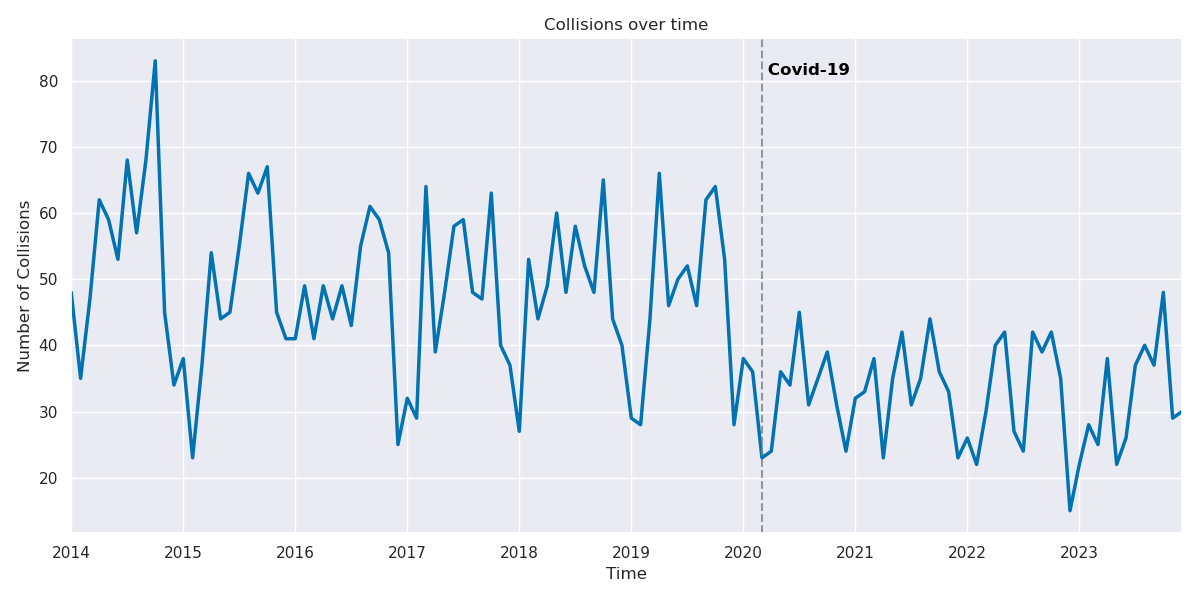

In [5]:
Image(filename = "figures/Collisions_by_year.png")

Looking at collisions by month, we see a general trend of less commuters during the winter months of December, January, and February. Brr!

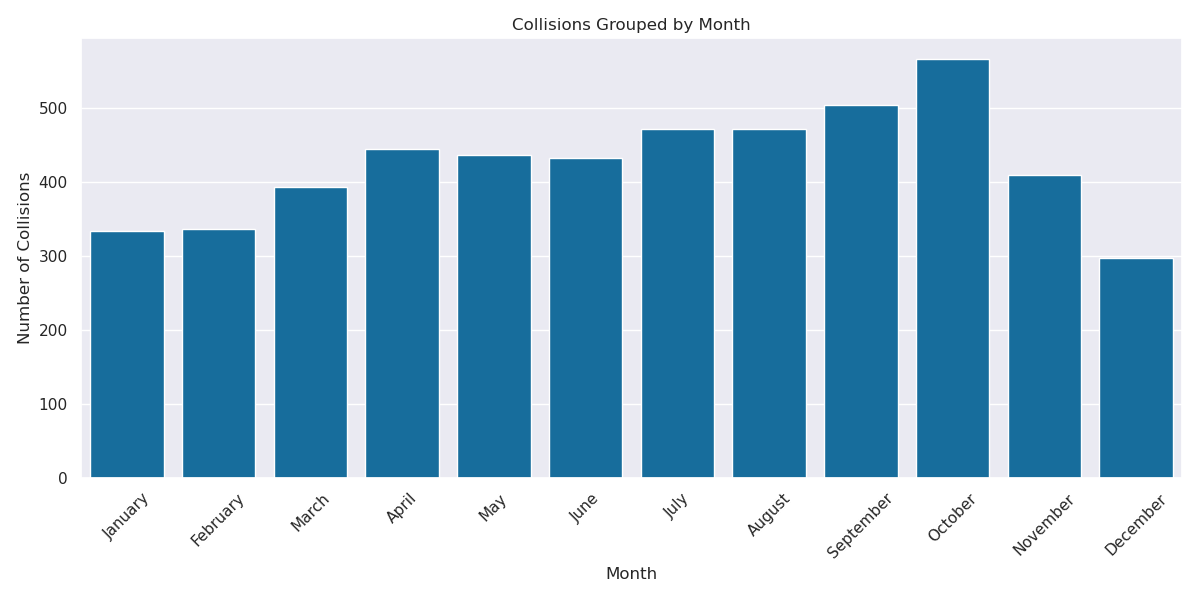

In [6]:
Image(filename = "figures/Collisions_by_month.png")

As shown in the figure below, there are no very obvious differences across seasons, in terms of categorical condition variation. However, there is certainly a marked differences in the number of crashes per season, with Winter having the lowest and Fall having the highest (cumulatively). We also note that Fall and Winter have more crashes in the dark, likely due to shorter days but unchanging work hours.

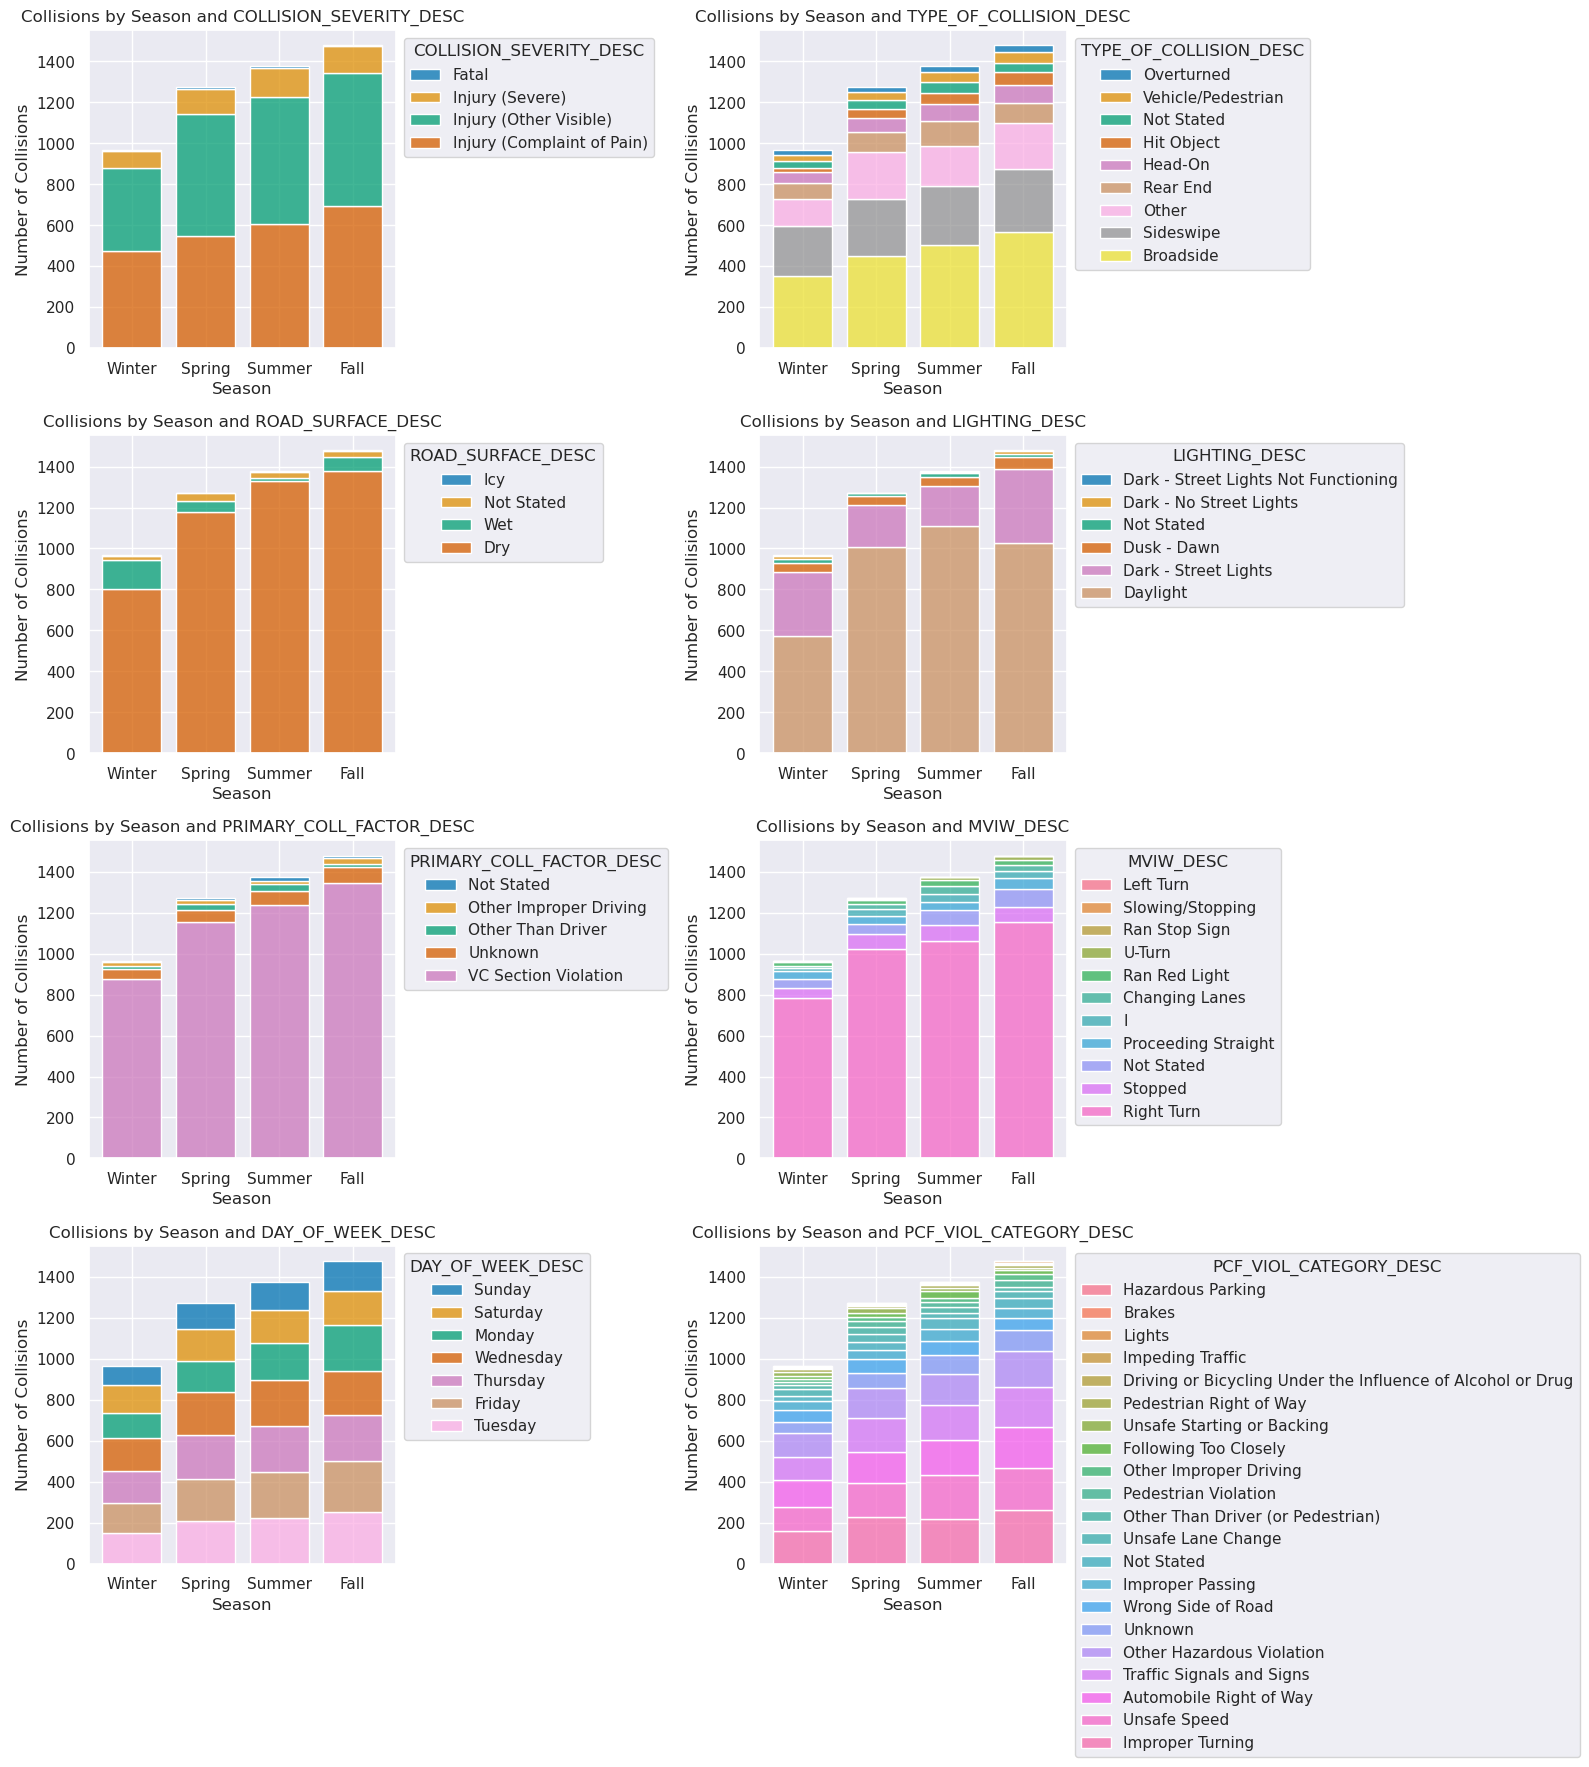

In [7]:
Image(filename = "figures/Collisions_Categories_by_Season.png")

We conducted the same categorical tests, but across days of the week. We see a noteable difference between the typical Monday - Friday work week with lower collision counts for the typical Saturday and Sunday weekend. 'Recreational' biking, we infer, is less of a contributor to SF's bike collisions as compared to commuting bike accidents, where bikers are commuting in the morning alongside cars and busses.  

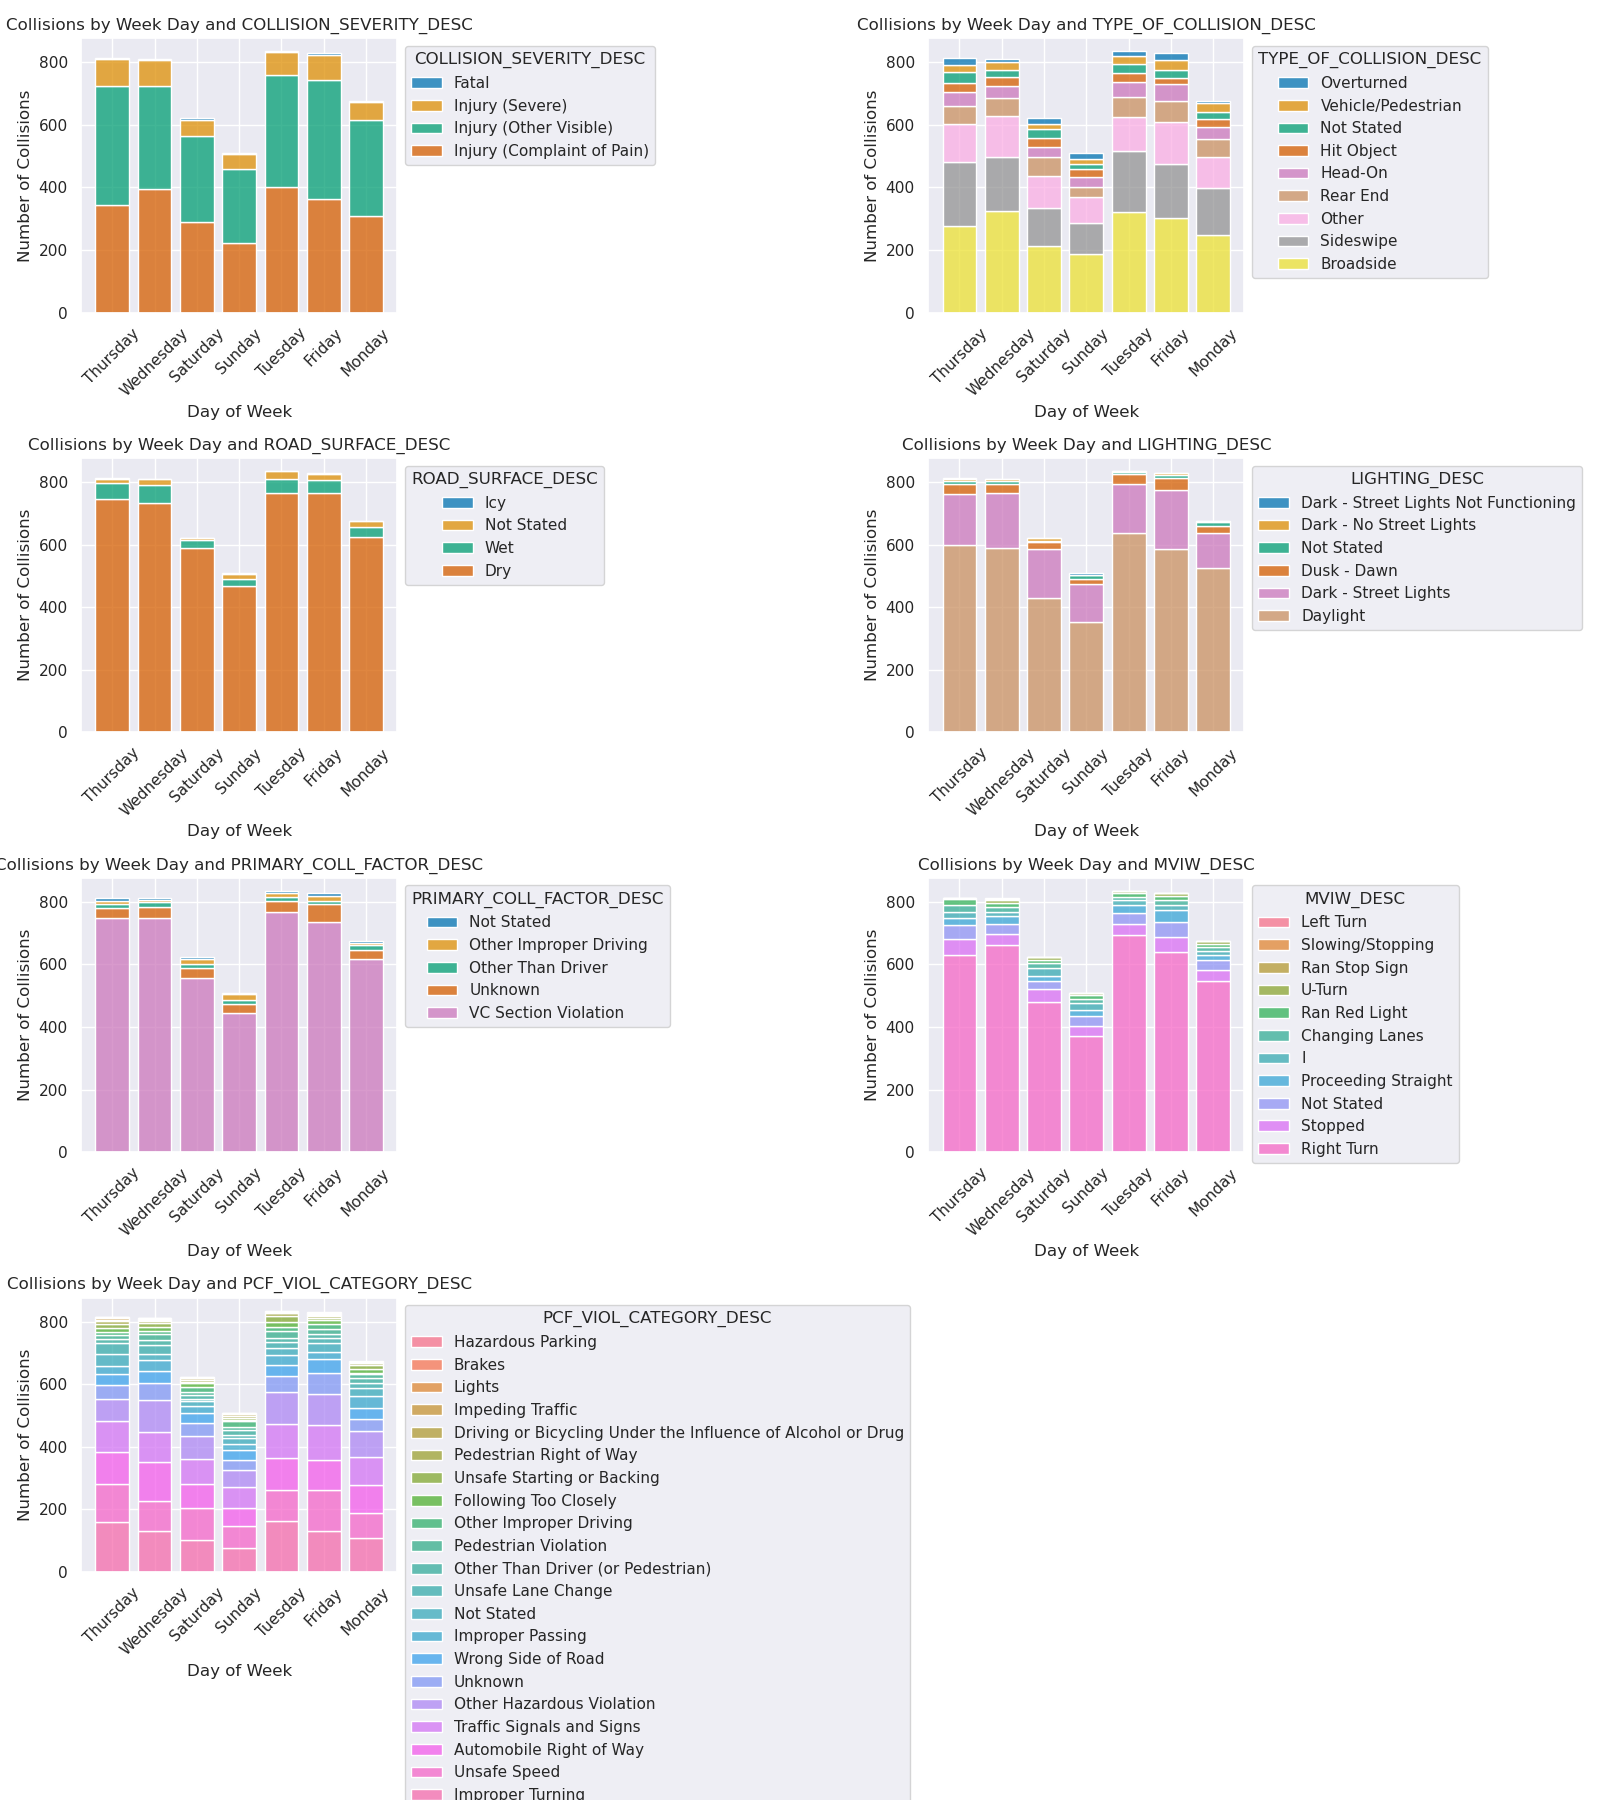

In [8]:
Image(filename = "figures/Collisions_Conditions_by_Day.png")

Next we explore the time of day and how that correlates with bike crashes. In the graphs below we observe that weekday crashes are markedly near morning and evening commute time of the 9-5 workday, while weekends follow a more normal distribution. The overwhelming majority of weekday crashes mean that the cumulative collision by time of day graph follows most closely with the weekday trends.

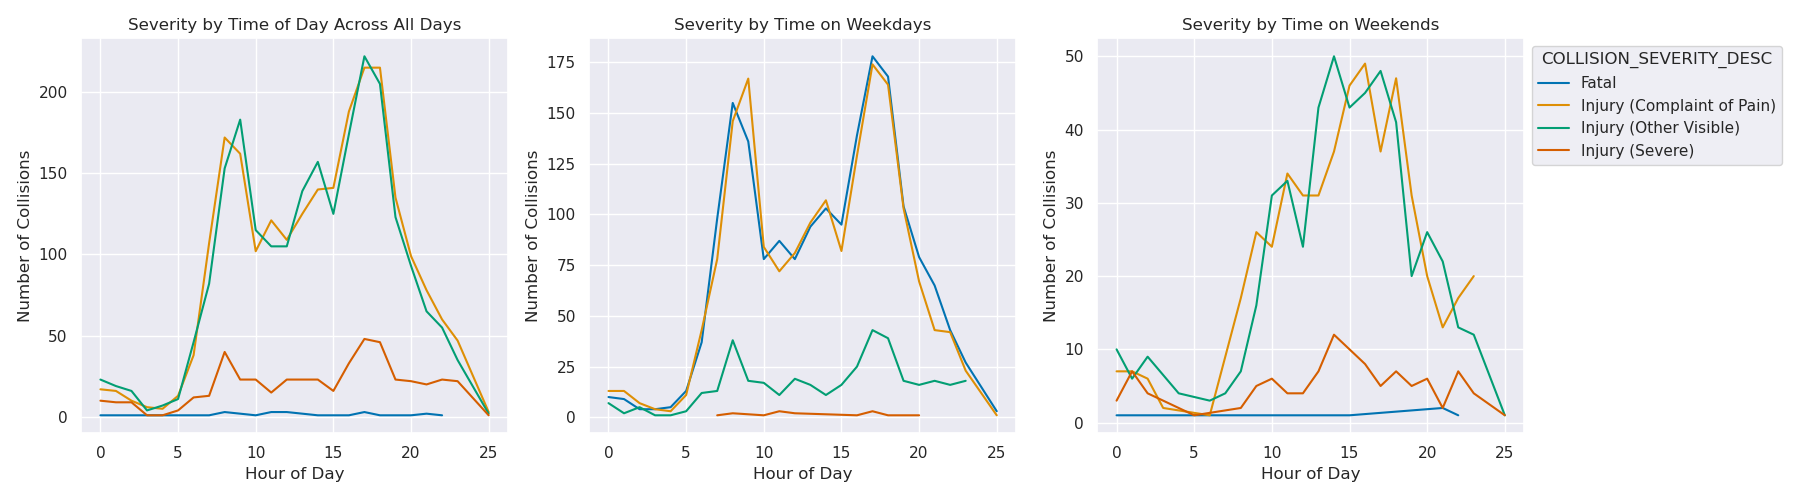

In [9]:
Image(filename = "figures/Collisions_by_TOD.png")

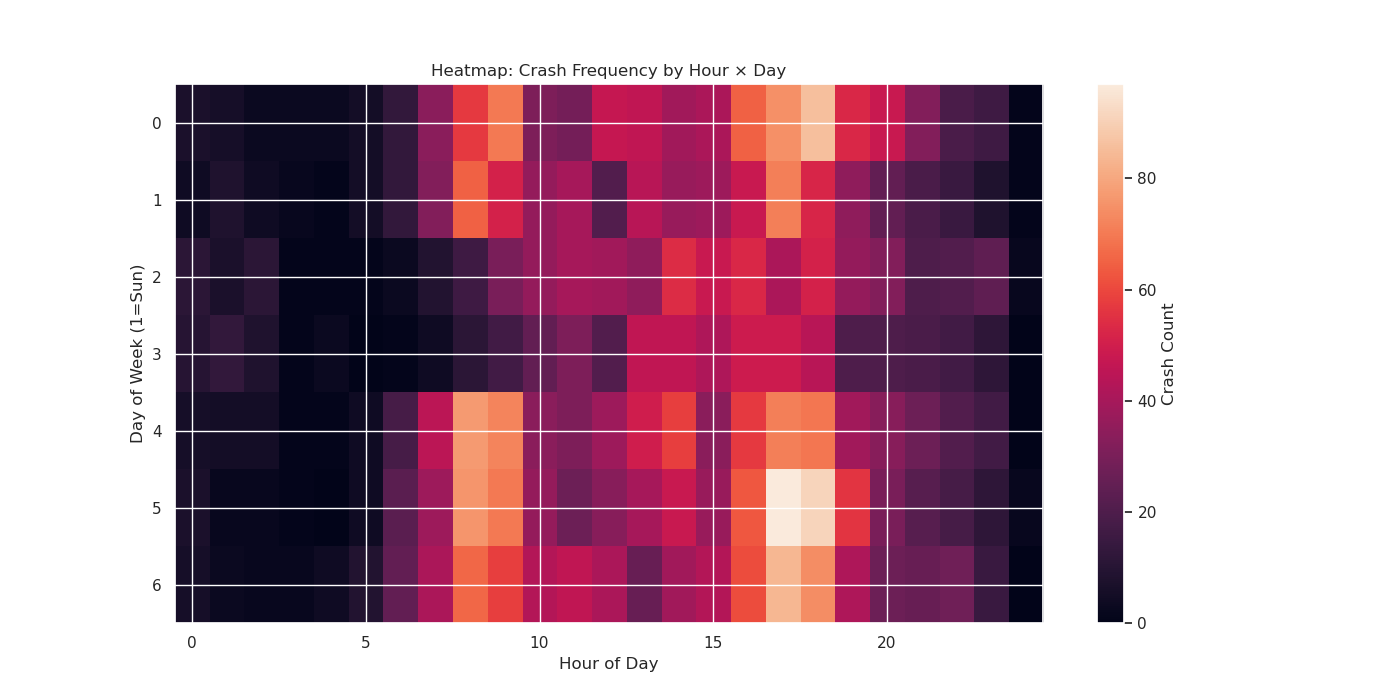

In [10]:
Image(filename = "figures/Crash_Heatmap.png")

#### Severe Crashes

The focal point of our research question is to understand the conditions that are present in the case of severe or fatal crashes. In the data visualizations below, we find a number of insights. Thankfully, the share of fatalities and severe injuries from bike crashes are extremely low compared to minor injuries. When looking at severity proportions by collision factors, a few things come to light. BUI's (Biking Under the Influence), biking on the wrong side of road, brake malfunctions, conditions other outside of the biker's control seem to have higher proportions of crash severity.

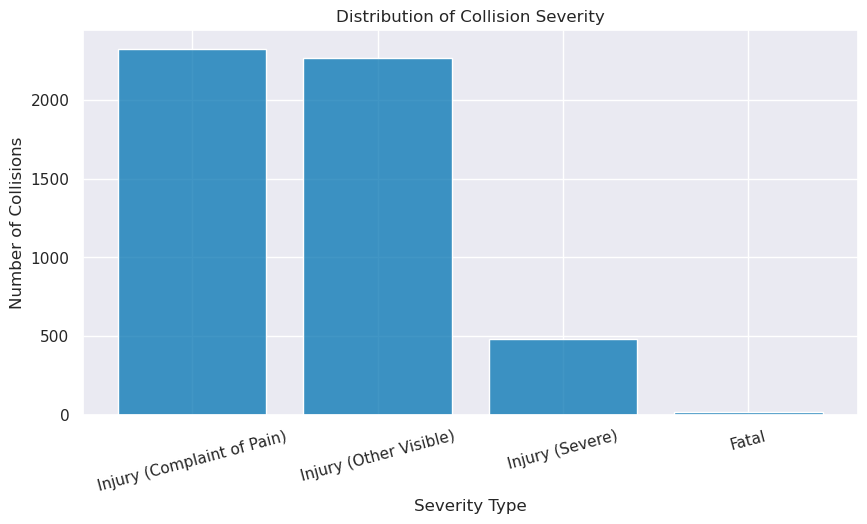

In [11]:
Image(filename = "figures/Distr_Collision_Severity.png")

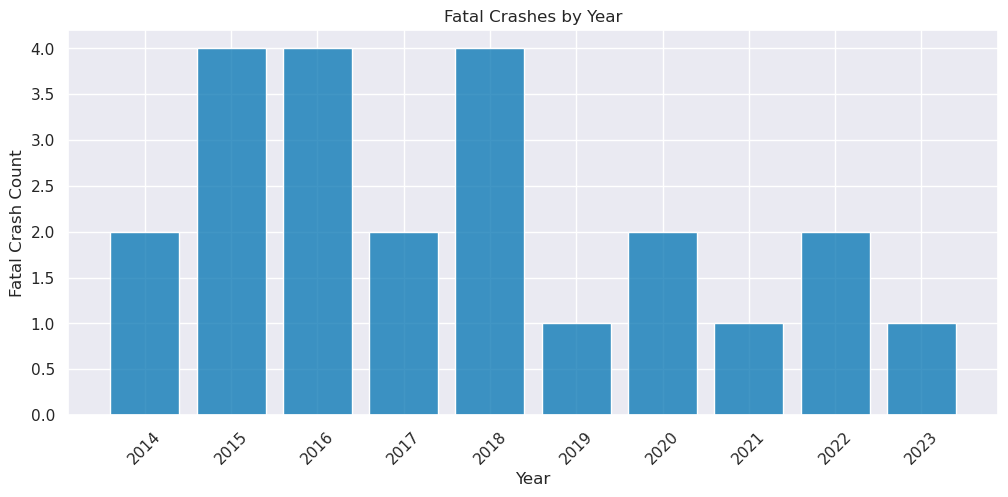

In [12]:
Image(filename = "figures/Fatalities_by_year.png")

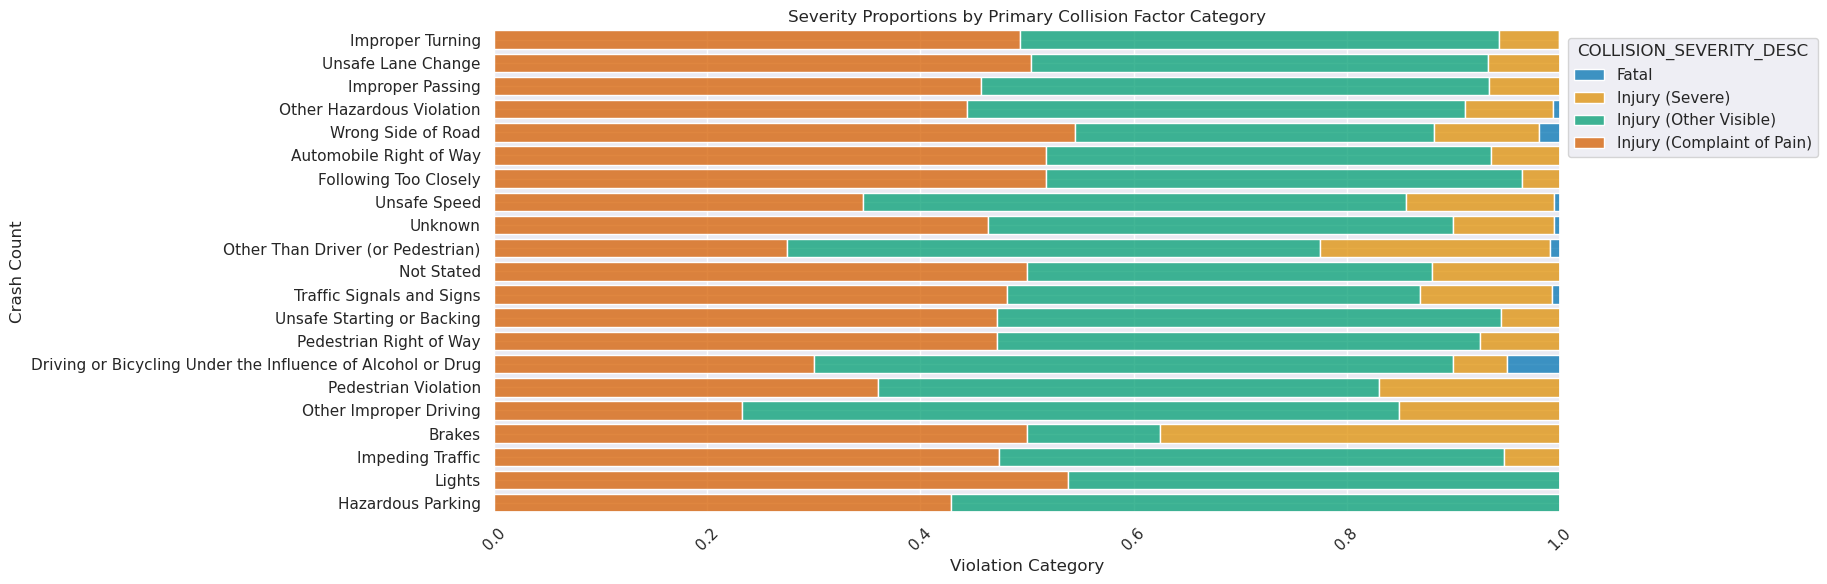

In [13]:
Image(filename = "figures/Collis_Factor_Proportions.png")

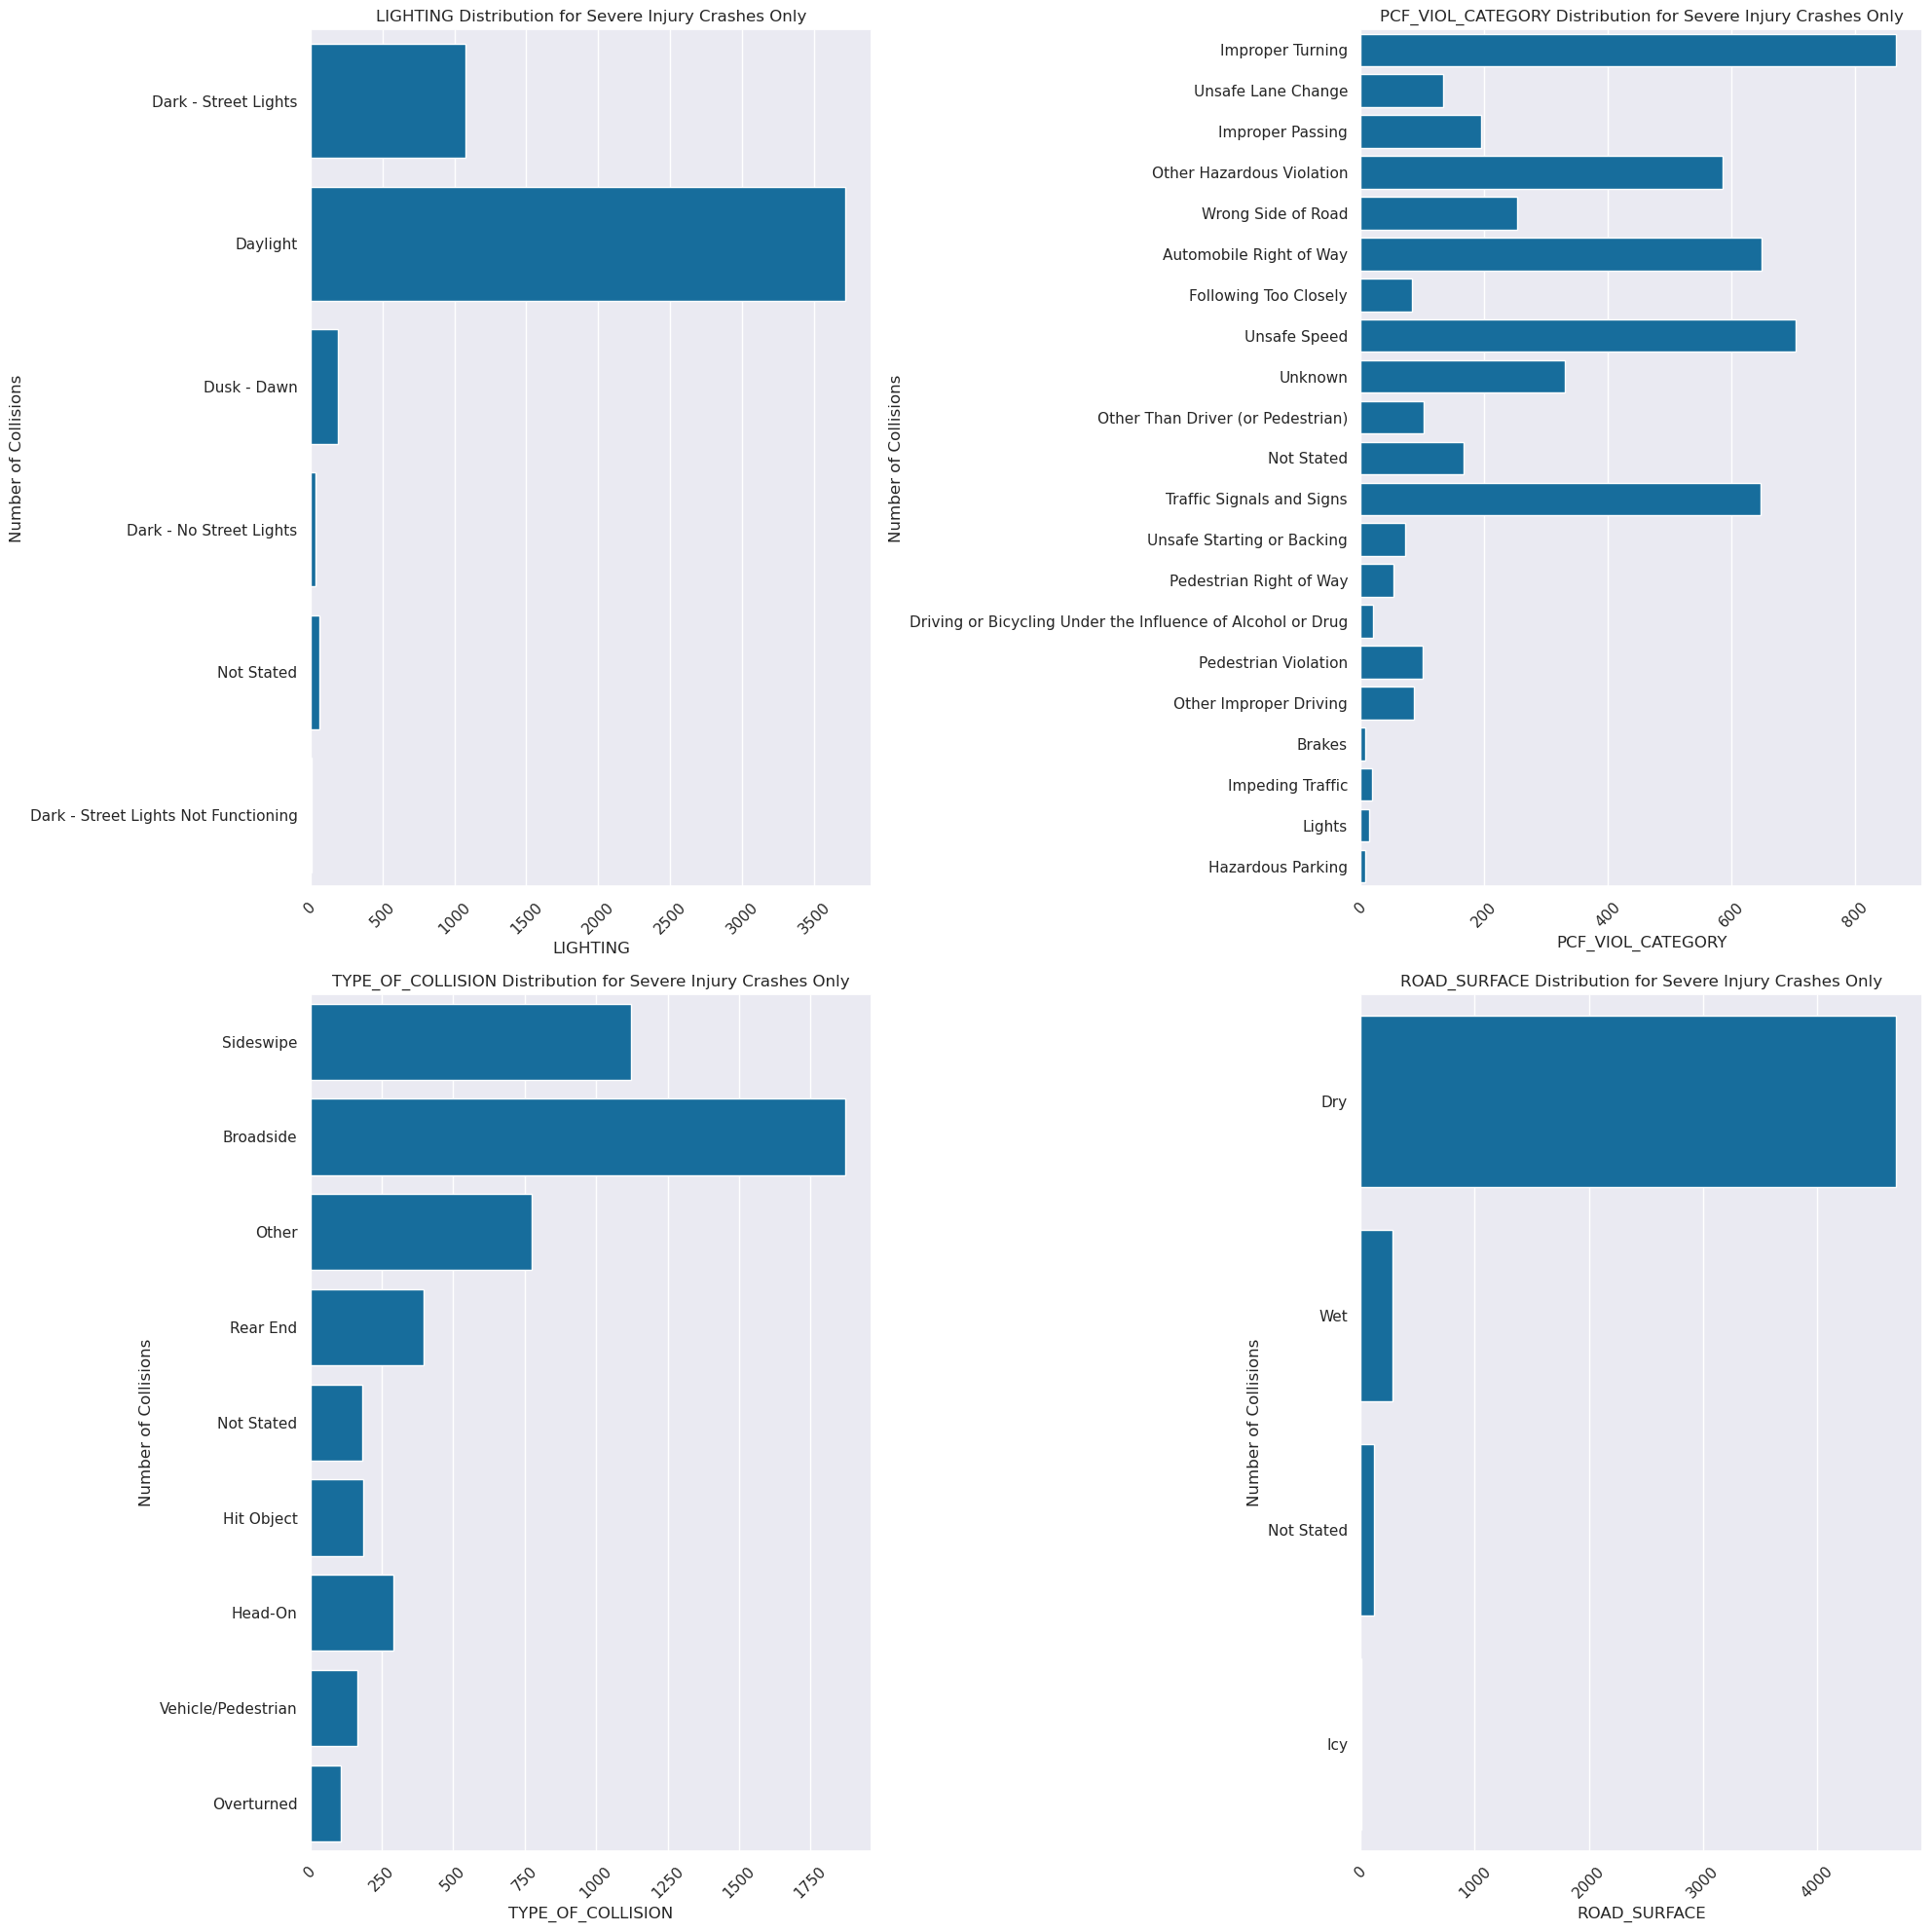

In [14]:
Image(filename = "figures/Severe_Conditions.png")

# Where do Severe Crashes Happen Often?

This section will use the Kernel Density Estimation (KDE) [@silverman1986density] and DBSCAN Clustering methods [@ester1996dbscan] to identify locations in San Francisco (SF) that see the highest amount of bike crashes. The KDE method combined with GeoPandas [@geopandas] will help visualize crash hotspots around SF. This analysis will continue with all severity of crashes to see if there are locations with greater severities than others.

It is important to note that it may be expected that more crashes will occur in locations where there is more bike/vehicle traffic. However, the infrastructure of the road should match the volume. Therefore, if a high-volume street is showing multiple crashes, that indicates that existing infrasturcture does not support the expected interactions, and infrastructure change would still be needed to address the higher crash occurances.

In [15]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx
from math import radians
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from shapely.geometry import Point

In [16]:
crashes = pd.read_csv("data/Crashes.csv")
crashes = crashes.dropna(subset=['POINT_X', 'POINT_Y'])

In [17]:
#Cleaning data set so that latitudinal and longitudinal outliers are ignored
crashes_clean = crashes[
    (crashes['POINT_X'] > -123) & (crashes['POINT_X'] < -121) &  # reasonable longitudes
    (crashes['POINT_Y'] > 37)   & (crashes['POINT_Y'] < 38.5) ].copy()   # reasonable latitudes

## Crash Severity
<br>
The following figures show the following:<br>
1. All crashes for all years
2. Fatal Crashes
3. Crashes with Severe Injury
4. Crashes with Visible Injury
5. Crashes where there is a Complaint of  Pain

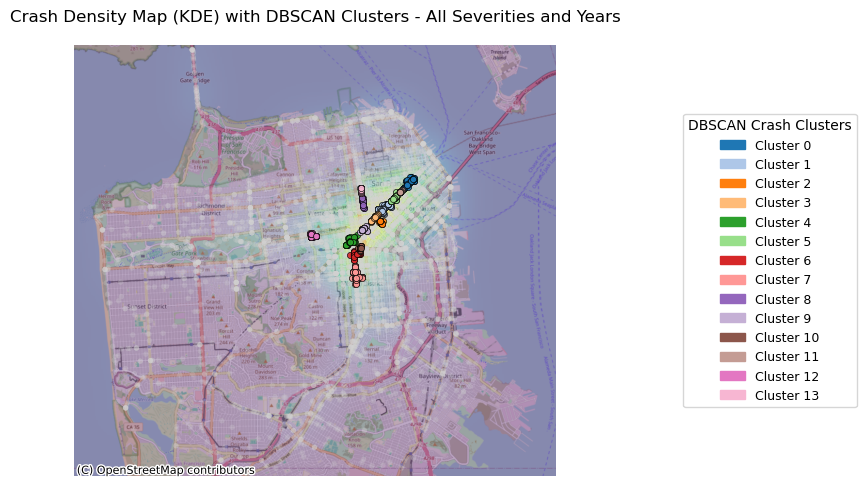

<Figure size 640x480 with 0 Axes>

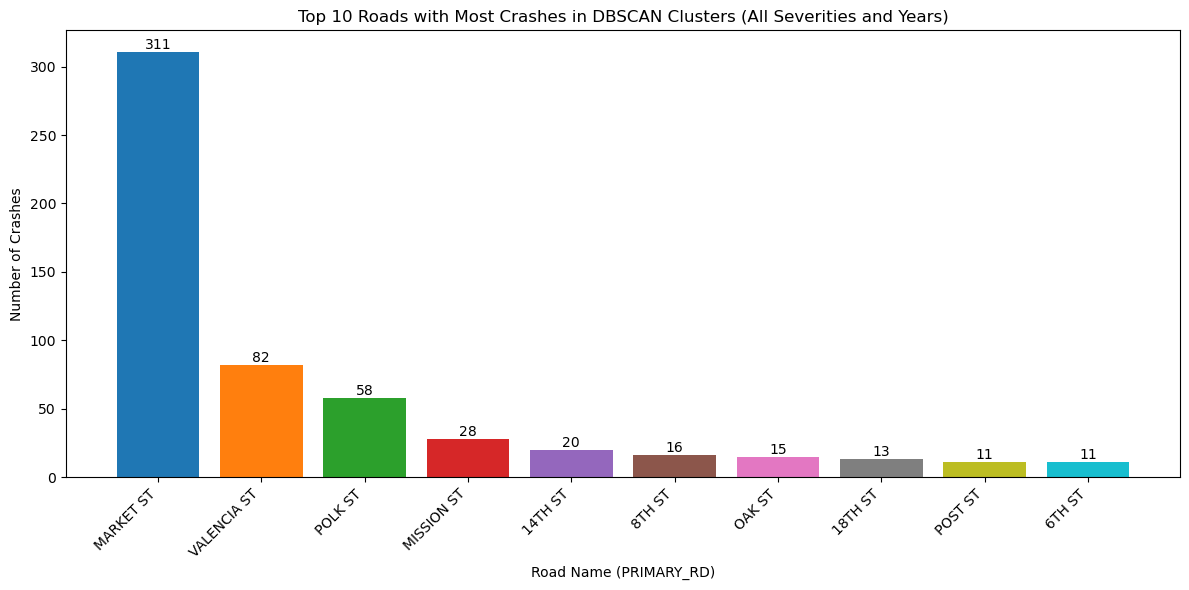

<Figure size 640x480 with 0 Axes>

In [18]:
from tools.KDE import plot_crash_clusters, plot_top_roads_bar

crashes_clustered = plot_crash_clusters(crashes_clean, severity=None, year=None, eps_meters=100, min_samples=25,
                        title_suffix="All Severities and Years")
plot_top_roads_bar(crashes_clustered, top_n=10, severity=None, year=None, title_suffix="All Severities and Years")

The figure above illustrates all bicycle crashes available in the TIMS data set that occured between 2014 and 2024. The first map shows that the highest density of crashes has occured in the downtown area of SF and the following bar graph indicates that there have been many crashes specifically on Market Street, which is corroborated by the map.

Now, lets break down these crashes by severity. Where do the most severe crashes occur? Is there another trend we can find?

/home/jovyan/project/final-group07/tools/KDE.py:103: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_noise.plot(ax=ax, color='lightgrey', markersize=15, alpha=0.25, edgecolor='none')


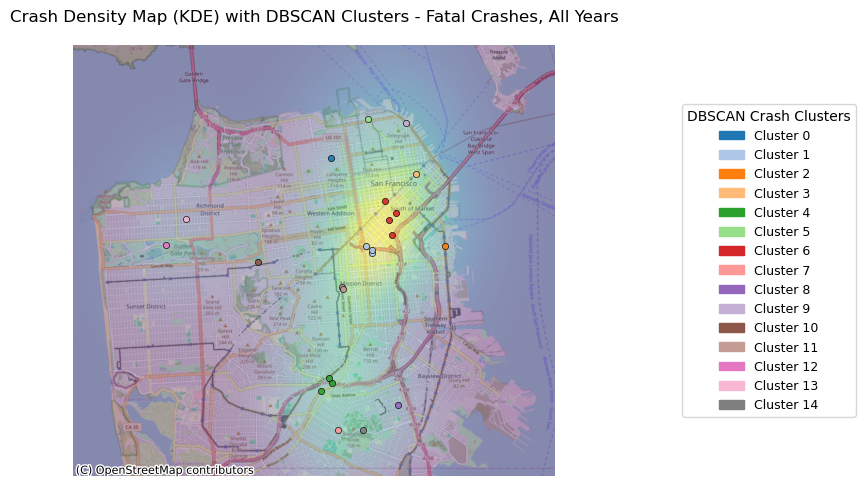

<Figure size 640x480 with 0 Axes>

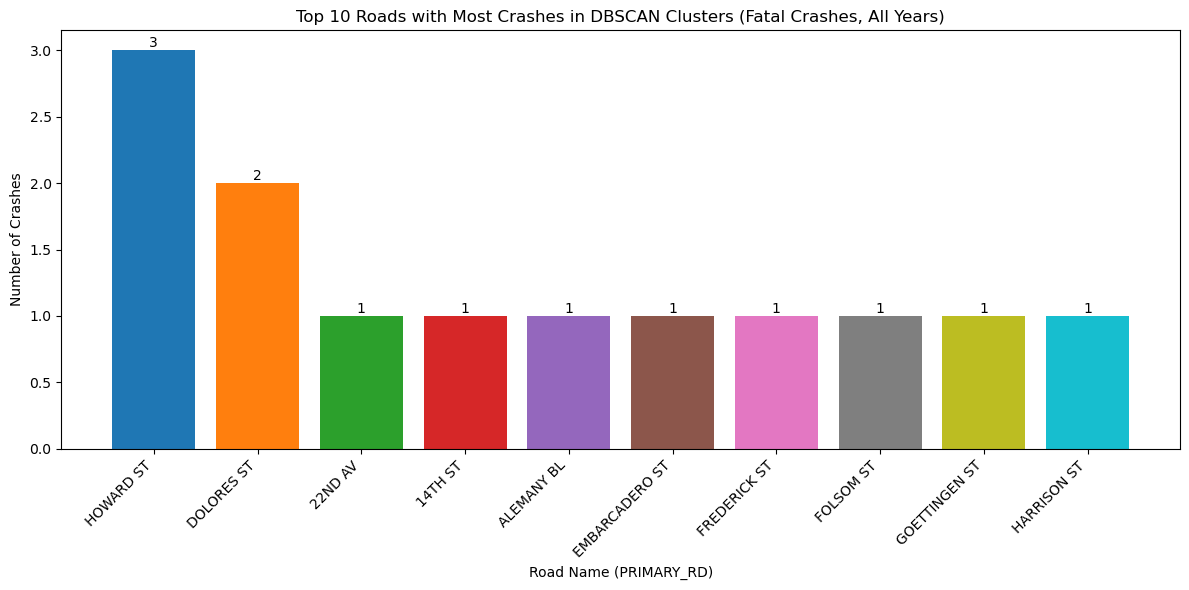

<Figure size 640x480 with 0 Axes>

In [19]:
fatal_crashes_clustered = plot_crash_clusters(crashes_clean, severity=1, year=None, eps_meters=500, min_samples=1,
                        title_suffix="Fatal Crashes, All Years")
plot_top_roads_bar(fatal_crashes_clustered, top_n=10, severity=None, year=None, title_suffix="Fatal Crashes, All Years")

Because there are so few fatal crashes, the minimum number of clusters for the analysis was set to 1 in order to visualize where the fatal crashes occured.

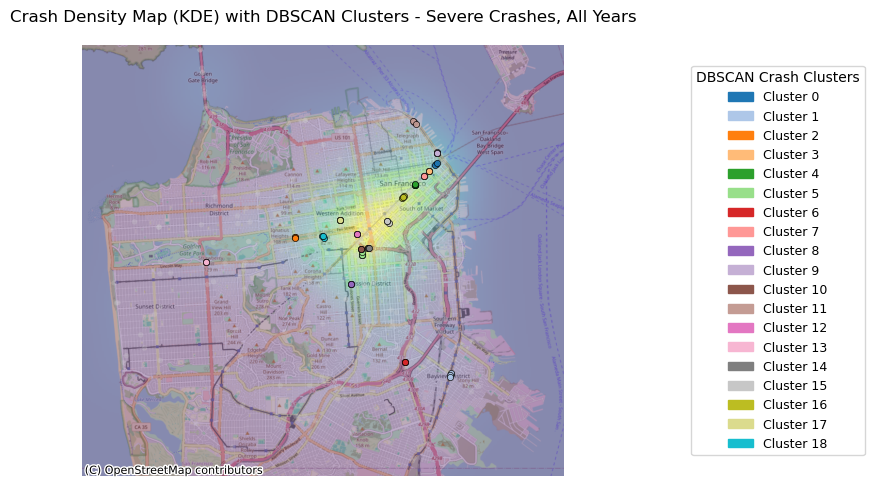

<Figure size 640x480 with 0 Axes>

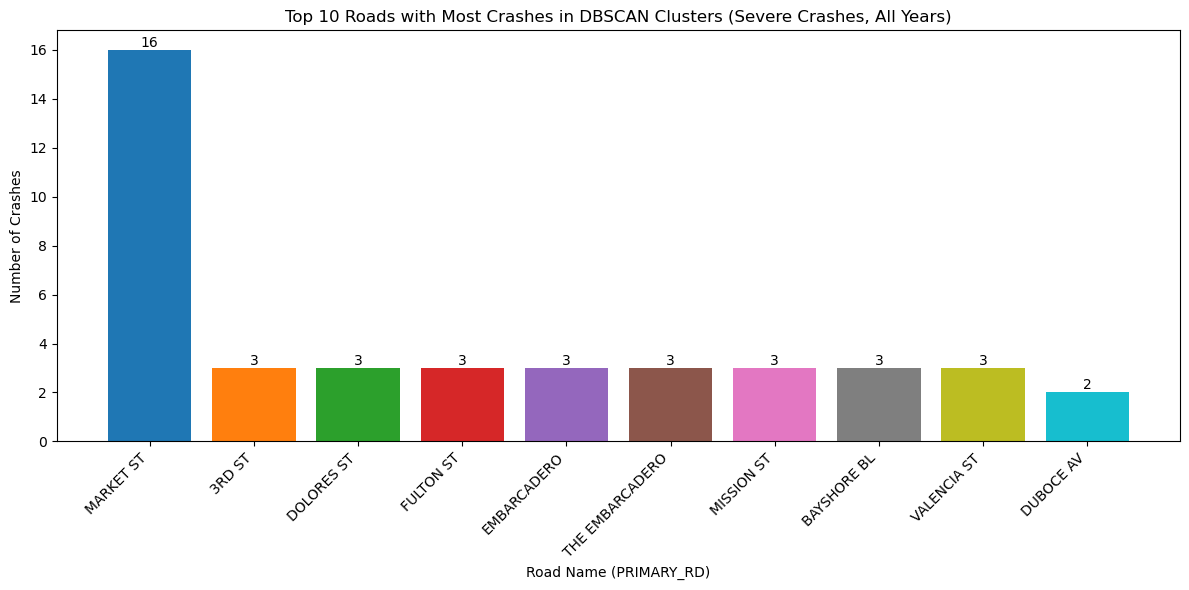

<Figure size 640x480 with 0 Axes>

In [20]:
severe_crashes_clustered = plot_crash_clusters(crashes_clean, severity=2, year=None, eps_meters=75, min_samples=3,
                        title_suffix="Severe Crashes, All Years")
plot_top_roads_bar(severe_crashes_clustered, top_n=10, severity=None, year=None, title_suffix="Severe Crashes, All Years")

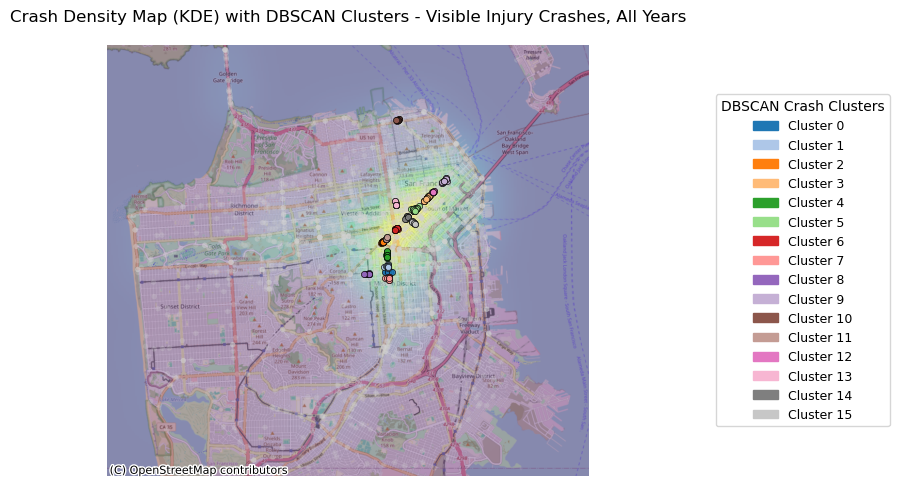

<Figure size 640x480 with 0 Axes>

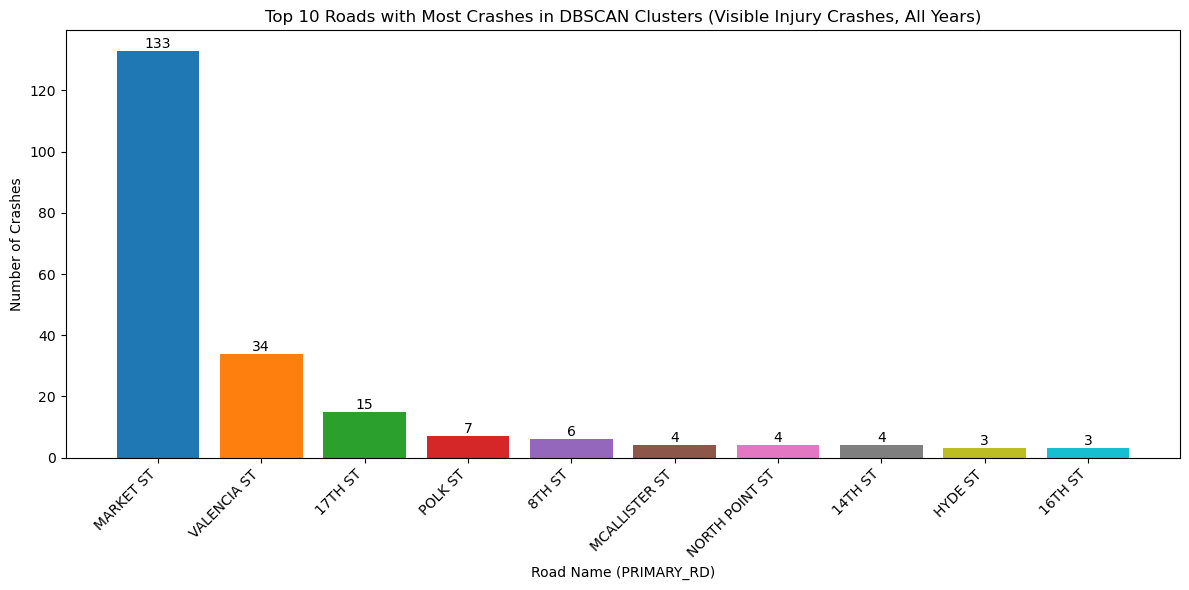

<Figure size 640x480 with 0 Axes>

In [21]:
injury_crashes_clustered = plot_crash_clusters(crashes_clean, severity=3, year=None, eps_meters=75, min_samples=10,
                        title_suffix="Visible Injury Crashes, All Years")
plot_top_roads_bar(injury_crashes_clustered, top_n=10, severity=None, year=None, title_suffix="Visible Injury Crashes, All Years")

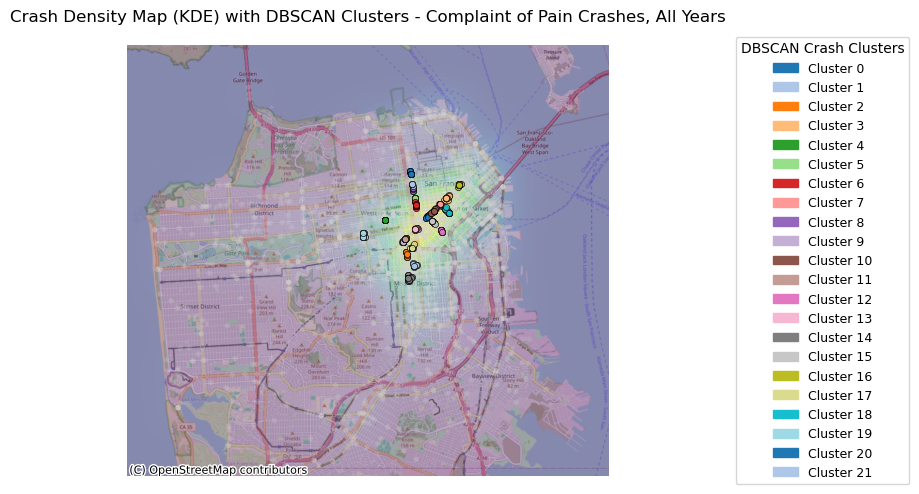

<Figure size 640x480 with 0 Axes>

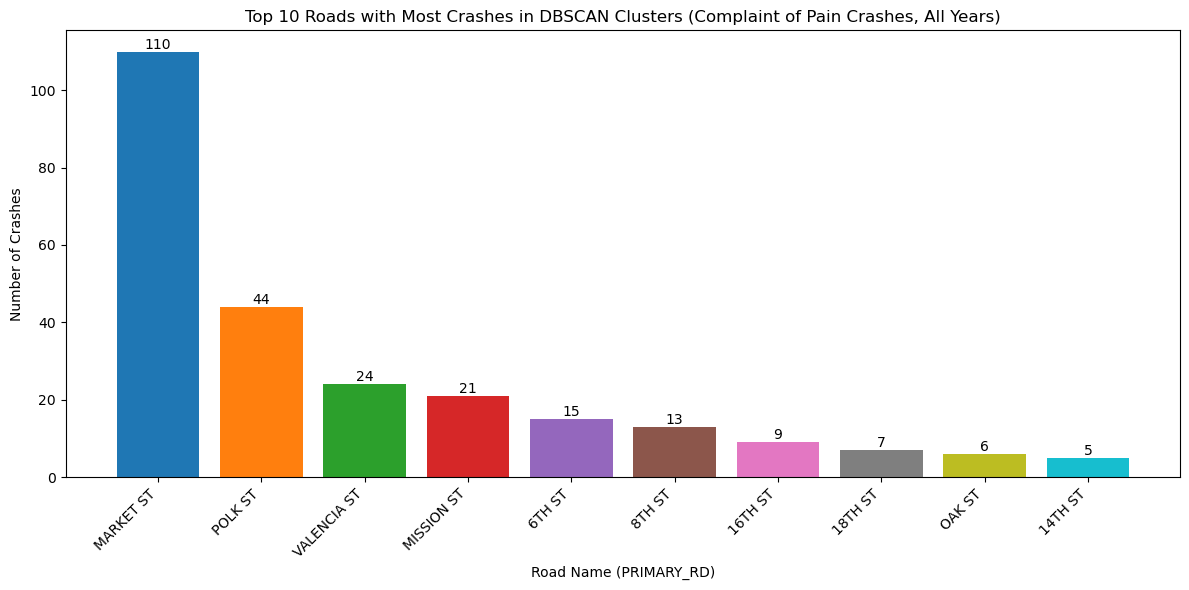

<Figure size 640x480 with 0 Axes>

In [22]:
cop_crashes_clustered = plot_crash_clusters(crashes_clean, severity=4, year=None, eps_meters=75, min_samples= 10,
                        title_suffix="Complaint of Pain Crashes, All Years")
plot_top_roads_bar(cop_crashes_clustered, top_n=10, severity=None, year=None, title_suffix="Complaint of Pain Crashes, All Years")

## Street Trends
The above graphs confirm a startling number of crashes densly clustered on Market Street. However, on January 29, 2020, Market Street was closed to motor vehicles, outside of emergency services and buses. We can see this difference in the two images below. One is from before January 29, 2020, and the other is from after this point.

![Crash map](KDE_images/MarketStPre.png) <br>
This is a picture of Market Street from before the vehicle ban. As shown in the photo, we see vehicles sharing space with bicyclists. These interactions increase the probablility of a crash.

![Crash map](KDE_images/MarketStPost.png) <br>
This is a picture of Market Street from after the vehicle ban. Less interaction between cars and bikes mean less chances of collision.

The change  means that interactions between cars and bikes are now almost zero, except for traffic crossing the street perpendicularly.  When we filter out crashes that occured after that date, we see the following.

In [23]:
# Turn to datetime format
crashes_clean['COLLISION_DATE'] = pd.to_datetime(
    crashes_clean['COLLISION_DATE'],
    errors='coerce'
)

# Filter crashes after 2020-01-29
crashes_recent = crashes_clean[
    crashes_clean['COLLISION_DATE'] > pd.Timestamp('2020-01-29')
]

/home/jovyan/project/final-group07/tools/KDE.py:103: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_noise.plot(ax=ax, color='lightgrey', markersize=15, alpha=0.25, edgecolor='none')


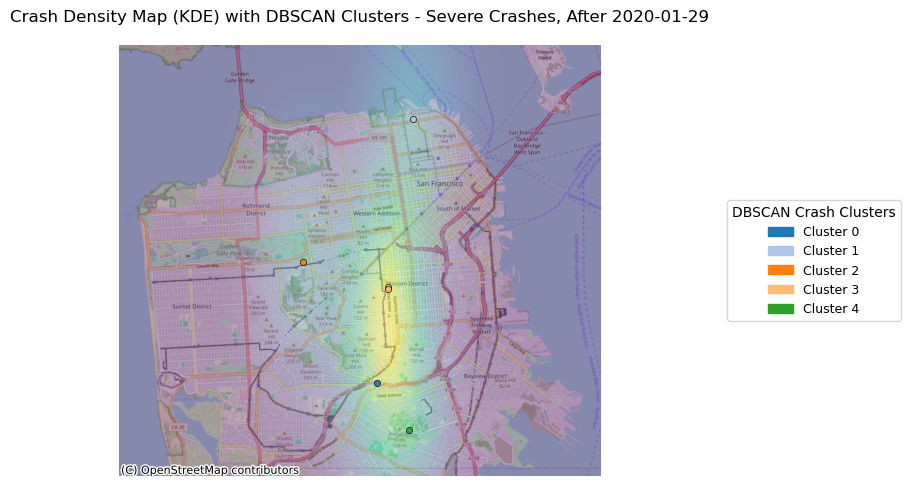

<Figure size 640x480 with 0 Axes>

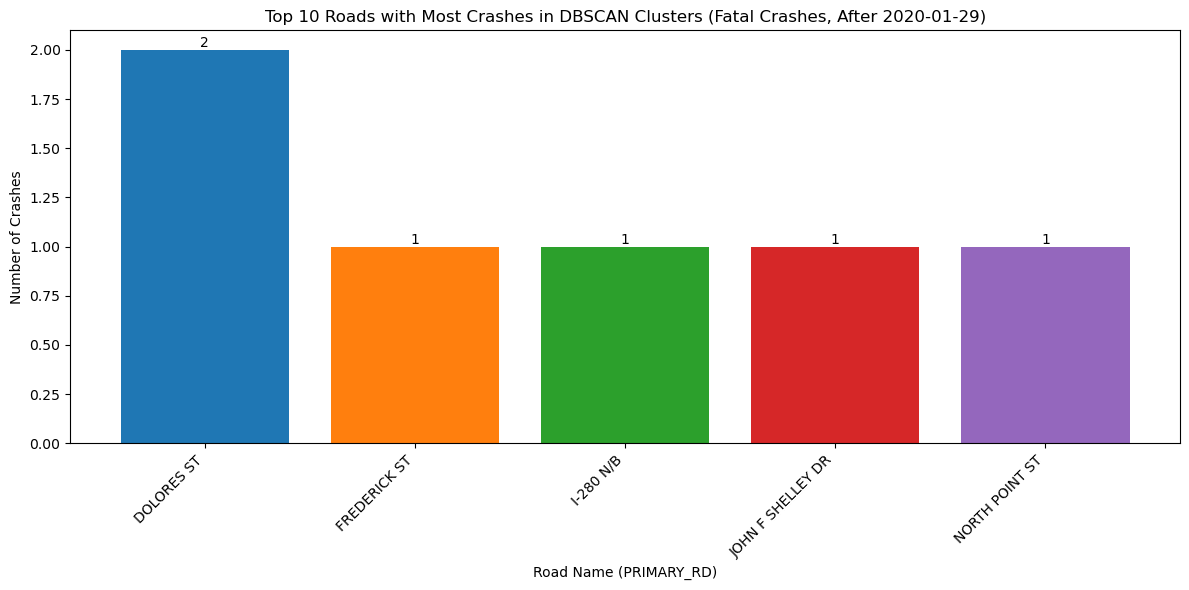

<Figure size 640x480 with 0 Axes>

In [24]:
fatal_recent_clustered = plot_crash_clusters(crashes_recent, severity=1, year=None, eps_meters=500, min_samples= 1,
                        title_suffix="Severe Crashes, After 2020-01-29")
plot_top_roads_bar(fatal_recent_clustered, top_n=10, severity=None, year=None, title_suffix="Fatal Crashes, After 2020-01-29")


Now that the time span has been decreased, there are even fewer crashes and the minimum number of clusters for the analysis was again set to 1 in order to visualize where the fatal crashes occured.

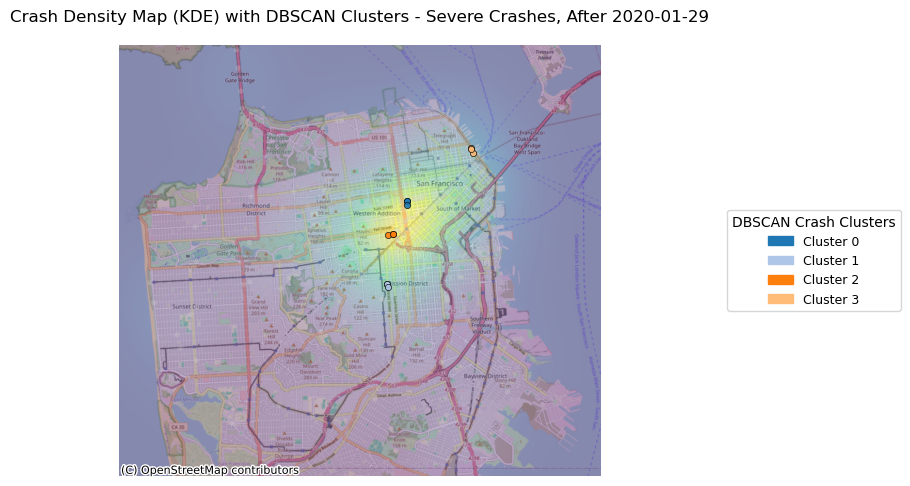

<Figure size 640x480 with 0 Axes>

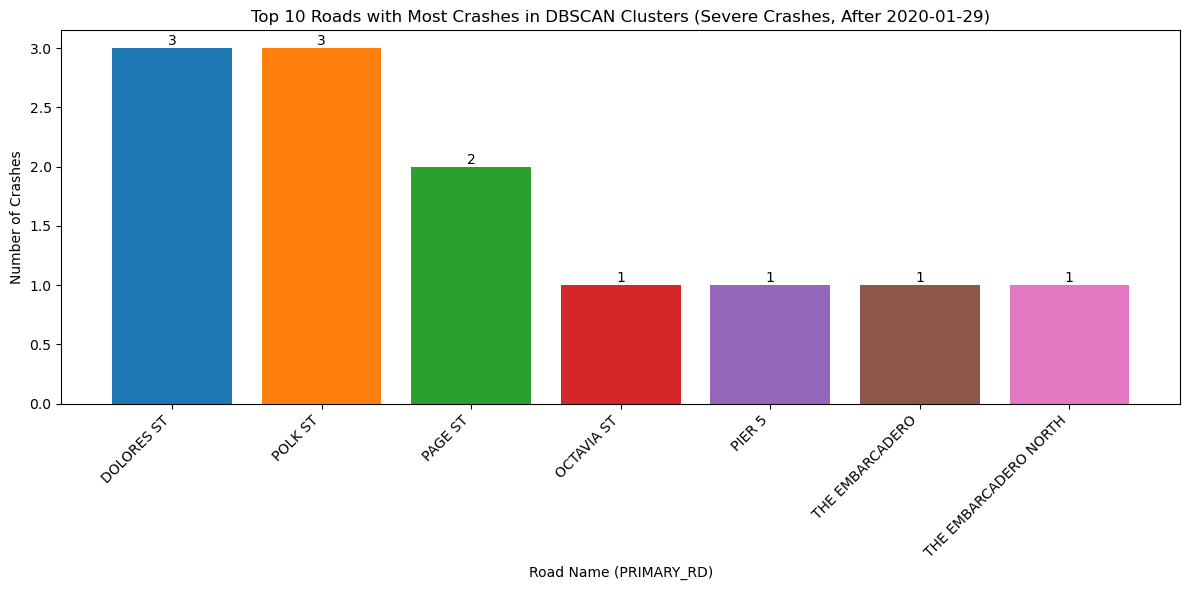

<Figure size 640x480 with 0 Axes>

In [25]:
severe_recent_clustered = plot_crash_clusters(crashes_recent, severity=2, year=None, eps_meters=150, min_samples= 3,
                        title_suffix="Severe Crashes, After 2020-01-29")
plot_top_roads_bar(severe_recent_clustered, top_n=10, severity=None, year=None, title_suffix="Severe Crashes, After 2020-01-29")


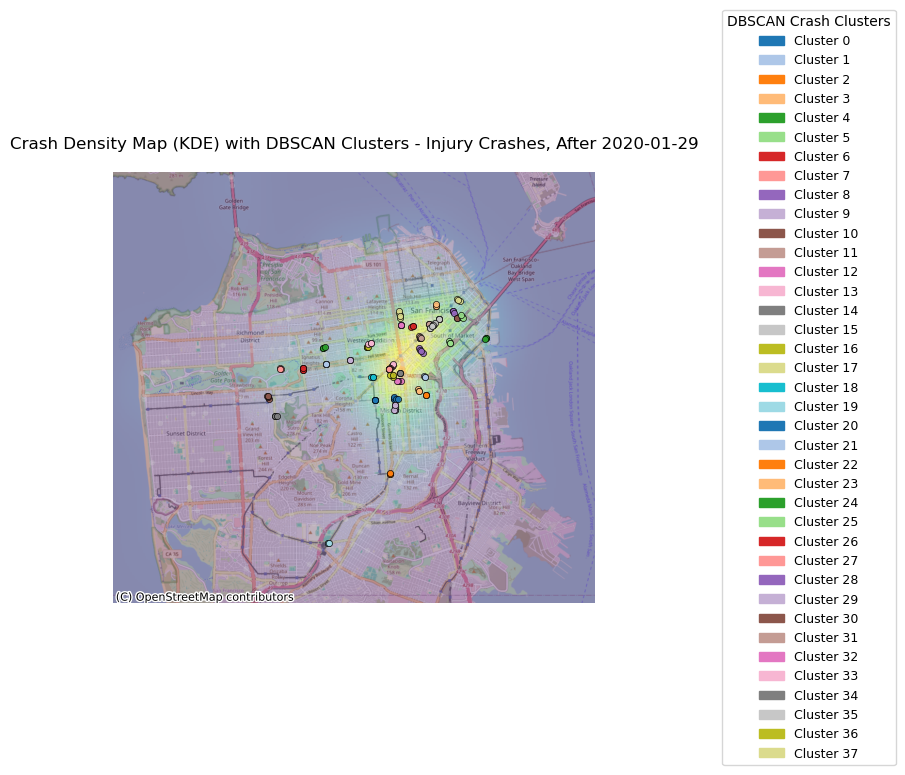

<Figure size 640x480 with 0 Axes>

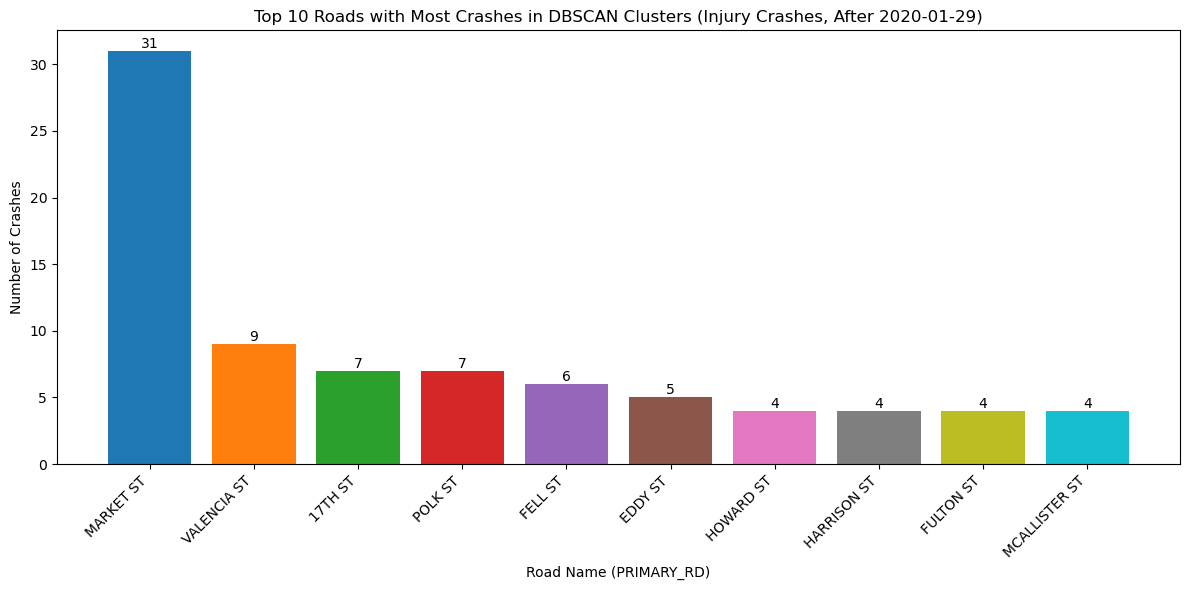

<Figure size 640x480 with 0 Axes>

In [26]:
injury_recent_clustered = plot_crash_clusters(crashes_recent, severity=3, year=None, eps_meters=75, min_samples= 3,
                        title_suffix="Injury Crashes, After 2020-01-29")
plot_top_roads_bar(injury_recent_clustered, top_n=10, severity=None, year=None, title_suffix="Injury Crashes, After 2020-01-29")


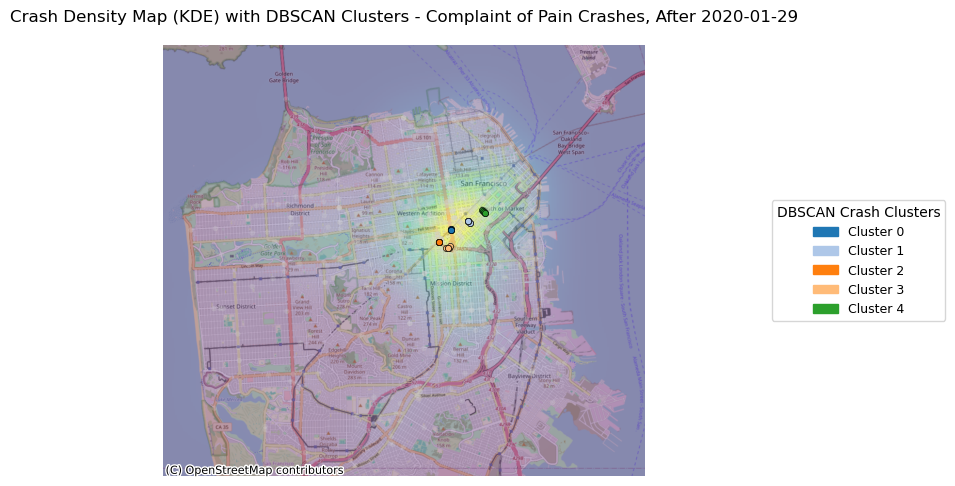

<Figure size 640x480 with 0 Axes>

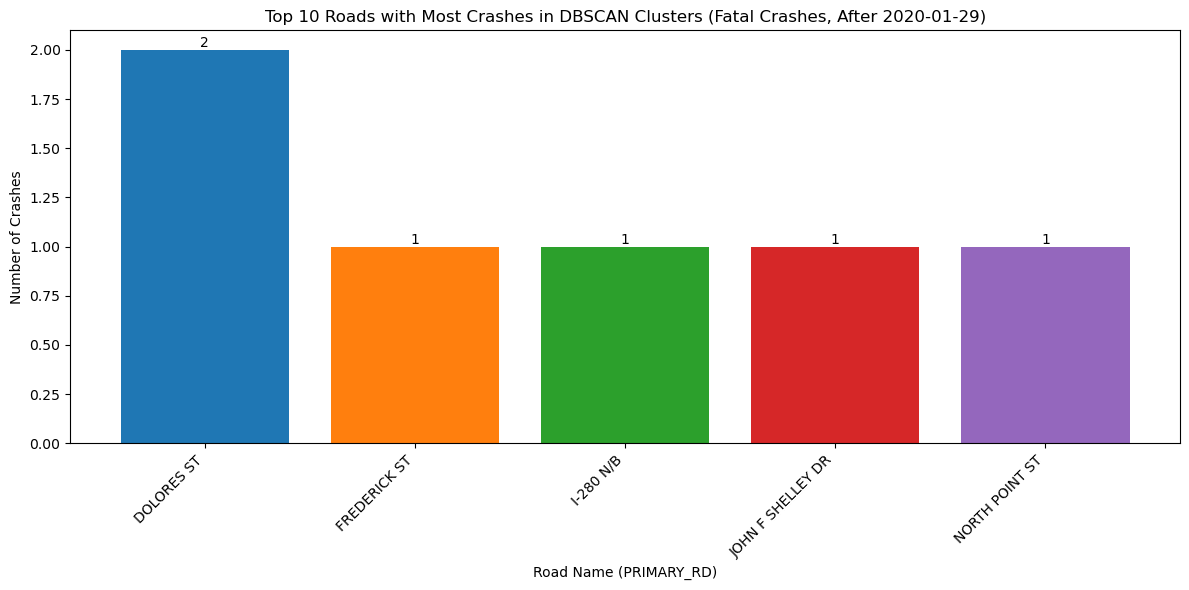

<Figure size 640x480 with 0 Axes>

In [27]:
cop_recent_clustered = plot_crash_clusters(crashes_recent, severity=4, year=None, eps_meters=75, min_samples= 5,
                        title_suffix="Complaint of Pain Crashes, After 2020-01-29")
plot_top_roads_bar(fatal_recent_clustered, top_n=10, severity=None, year=None, title_suffix="Fatal Crashes, After 2020-01-29")


With the change in vehicle allowance on Market Street, it is not surprising that Market Street no longer consistently comes up as a road with an exorbinant amount of crashes. Interestingly, it still appears to have many clustered crashes resulting in visible injuries. However, more consistently, we see roads such as Dolores Street, Frederick Street, and Polk Street. Even when looking at the data over all years, we can see that these three streets appear to have more crashes and are consistently flagged.
<br>
This indicates that there may be infrastructure characteristics that influence the propensity of bicycle crashes on these roads. 

![Crash map](KDE_images/DoloresSt.png)
<br>
The above image shows Dolores Street, which does not have bike lanes or any protective considerations for those who may use different modes of travel such as bicycles, scooters, or skateboards. Dolores Street shows high levels of bicyclist fatalities and severe injuries since 2020. This trend may justify the need for greater bicycle safety considerations such as bike lanes.

![Crash map](KDE_images/FrederickSt.png)
<br>
Similar to Dolores Street, Frederick Street also does not have bike lanes. Adding these protections and possibly other safety measures such as speed calming measures, more robust infrastructure, or greater signage could help decrease instances of bike collisions.

![Crash map](KDE_images/PolkSt.png)
<br>
Polk Street has better bicycle infrastructure; however, it was inconsistent. Some of the bike lane has vertical infrastructure, while other places do not. Further, there are many access points along Polk, such as perpendicular streets and driveways. These are generally unsafe conditions as they create multiple possible interaction points where crashes may occur. Special design considerations should be made that could protect cyclists. Making this street a slow street could be the best way to ensure that any collision that does happen is of the lowest severity.

Photo Credit: Google Maps

## Author Contributions

Author Contributions section: your main.ipynb notebook should contain, at the end, a brief section titled Author Contributions. This section should indicate, for each team member, what they did in the project. It doesn’t have to be a long, detailed story, a few sentences per person should suffice. All team members must agree to the language in this section. (By the way, this is standard practice in many scientific journals). While in principle the project grade is the same for all team members, we reserve the right to lower the grade of anyone who doesn’t contribute to the team effort.

- Reily Fairchild: Did the initial set up of the notebook, setting up the environment, makefile, tools, and myst files. Collaborated with Aditya on EDA, and then individually set that section in a strong narrative framing and consistent graph visuals.
- Jordan Collins: Did the spatial analysis and review of files near the end of the project.
- Aditya Mangalampalli: Worked on the packaging of our utility package `tools` by adding unit tests, helped contribute to the `Makefile`, set up the `mystmd` and it's respective Github Pages hosting, added appropriate licensing, populated the `README` with important information about the project, and collaborated with Reily on EDA.


## References